##This notebook focus on implementing linear regression on iris dataset
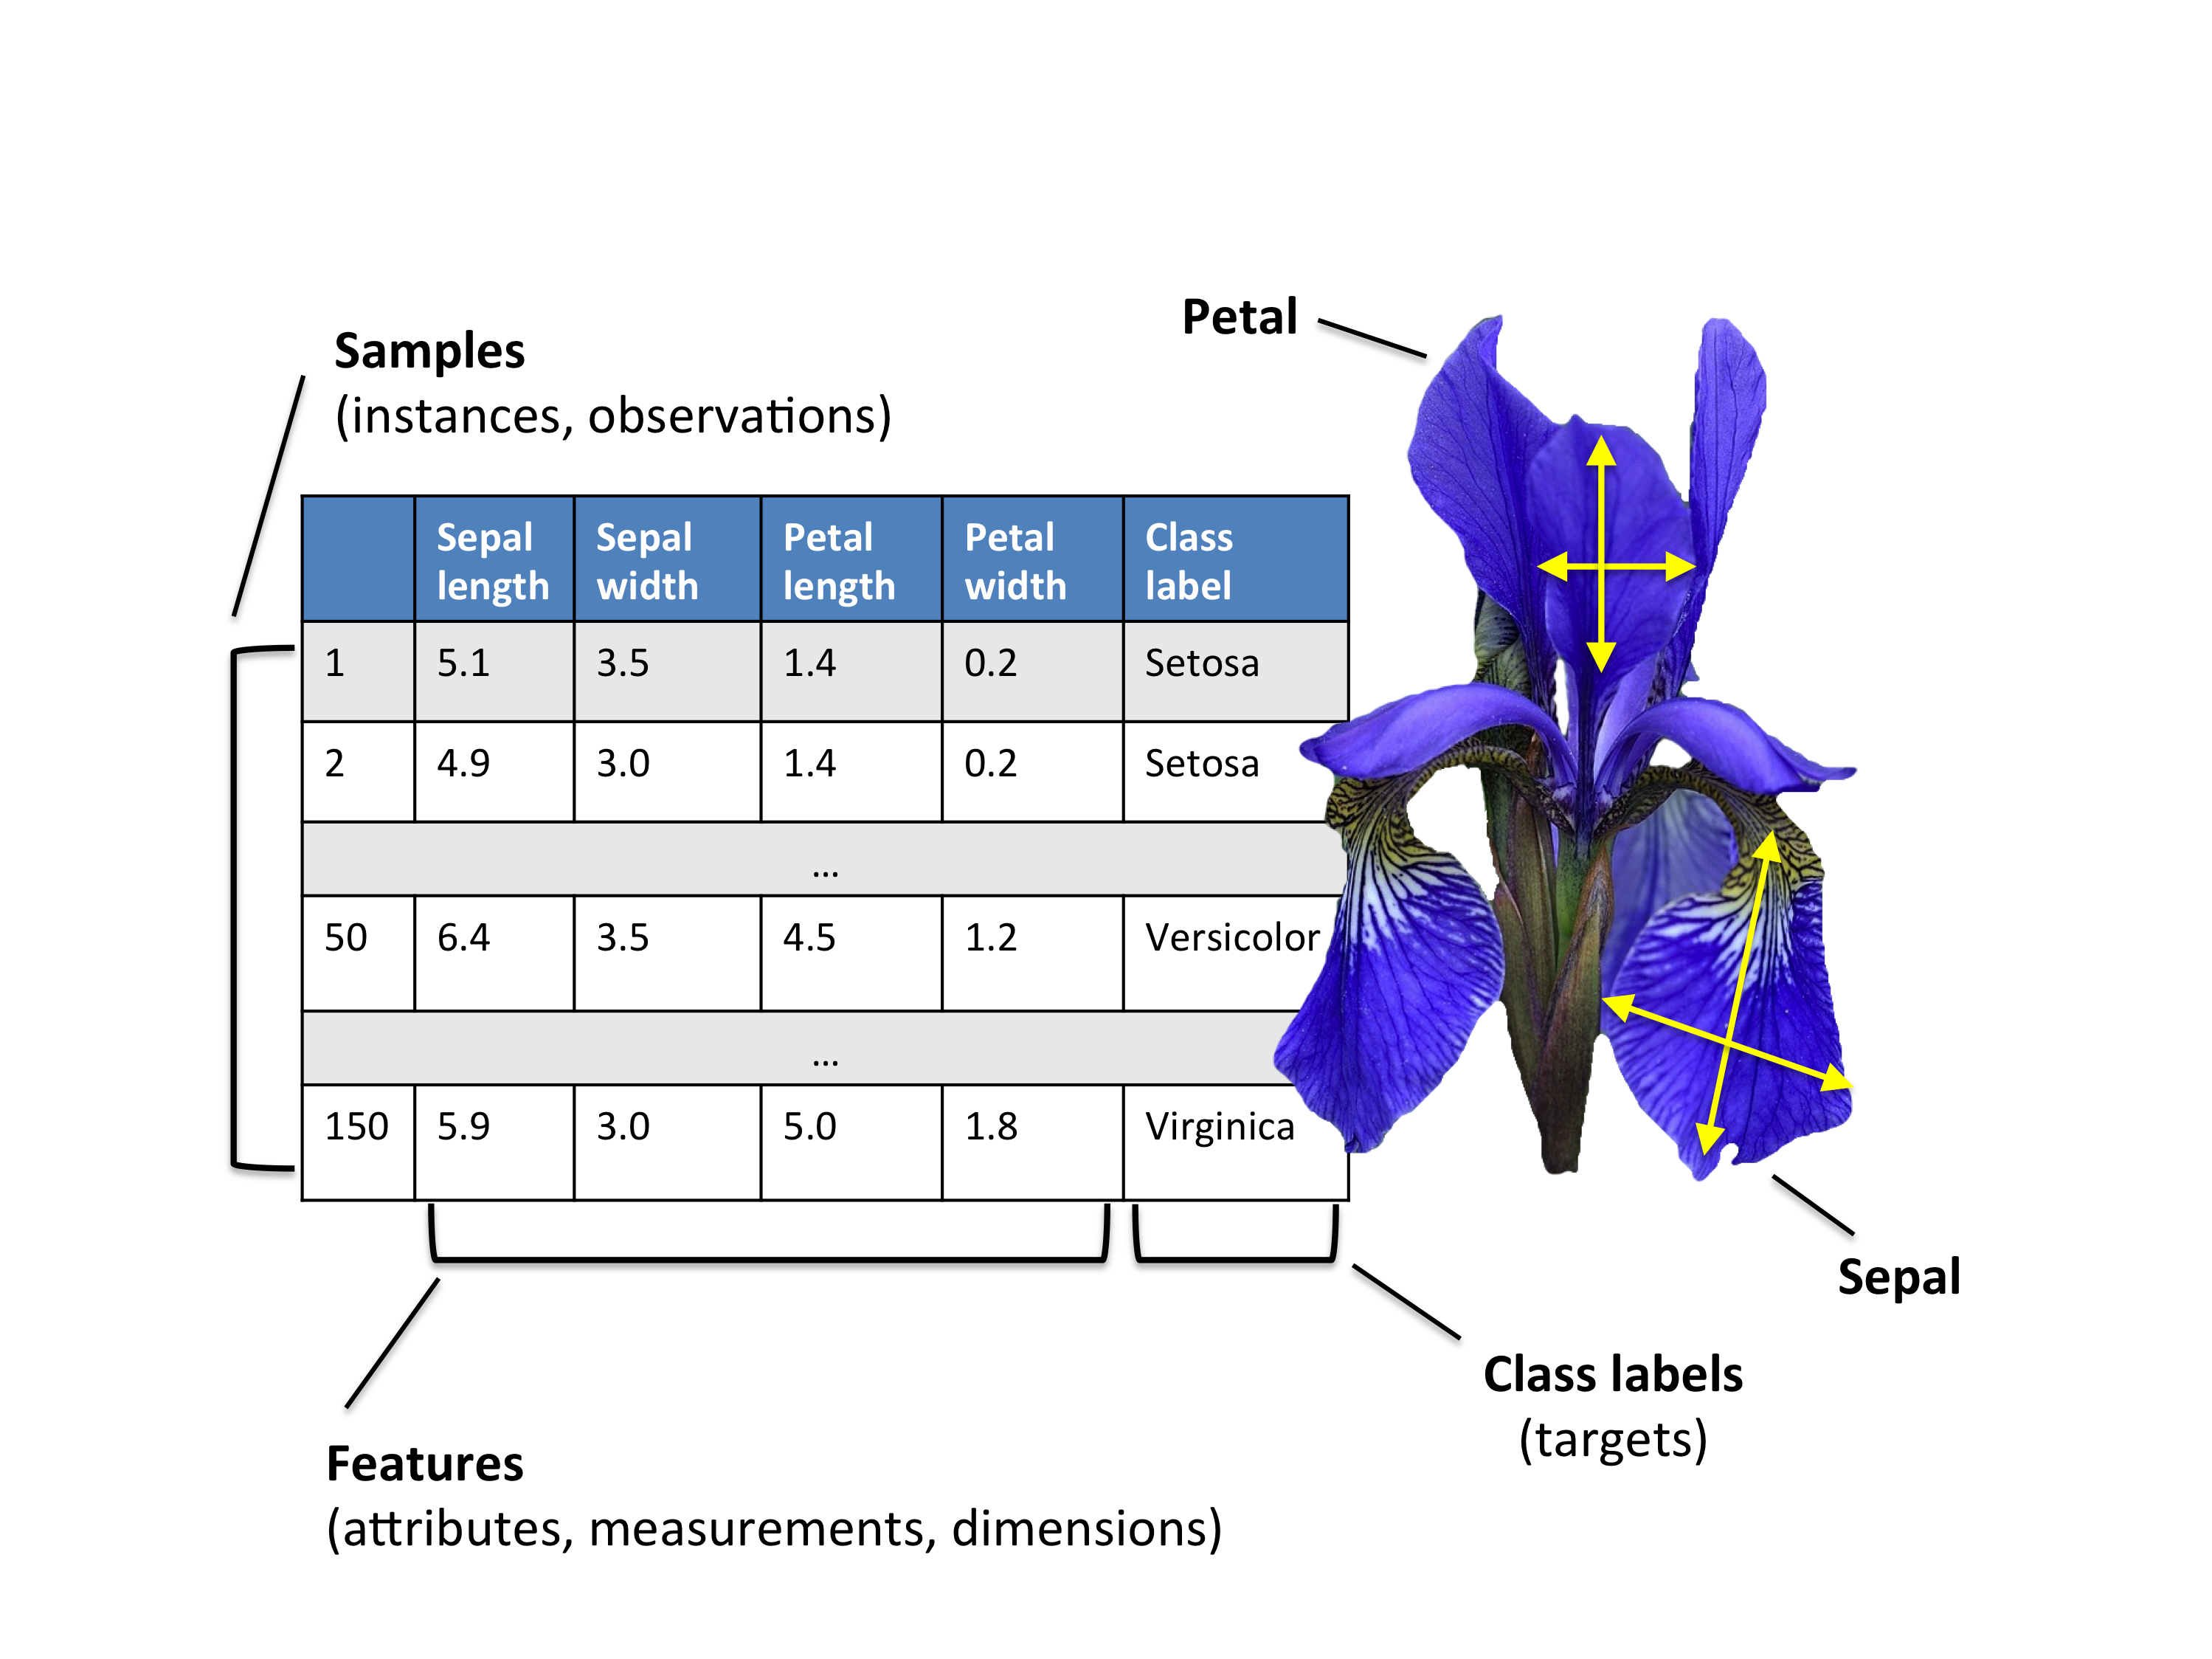

## 
Why am I using iris dataset:

1- This is a good project because it is so well understood.

2- Attributes are numeric so you have to figure out how to load and handle data.

3- It is a classification problem, allowing you to practice with perhaps an easier type of supervised learning algorithm.

4- It is a multi-class classification problem (multi-nominal) that may require some specialized handling.

5- It only has 4 attributes and 150 rows, meaning it is small and easily fits into memory (and a screen or A4 page).

6- All of the numeric attributes are in the same units and the same scale, not requiring any special scaling or transforms to get started.

7- we can define problem as clustering(unsupervised algorithm) project too.

In [1]:
#Load iris dataset
import pandas as pd
import numpy as np
from sklearn import datasets
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

iris = datasets.load_iris()

X = iris.data[:, [2, 3]] # column #2 and #3 are petal length and width features
y = iris.target

iris_df = pd.DataFrame(X, columns=iris.feature_names[2:])

In [2]:
## Split the data into training and testing dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=0)

print('Training set length: {}.\nTest set length: {}'.format(X_train.shape[0], X_test.shape[0]))

Training set length: 112.
Test set length: 38


In [3]:
## Feature Scaling
from sklearn.preprocessing import StandardScaler

#from each value subtract its average and divide by the standard deviation
sc = StandardScaler()
sc.fit(X_train)

X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

print(pd.DataFrame(X_train_std, columns=iris_df.columns).head())

   petal length (cm)  petal width (cm)
0           0.225127          0.356382
1           0.113560         -0.028648
2           0.950314          1.126441
3          -1.392599         -1.312081
4           0.727180          1.383128


In [4]:
## Visualisation functions
def get_red_blue_green_cmap():
    colors = ('blue', 'green', 'red') #('red', 'blue', 'green')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    return cmap

In [5]:
def visualize_classification_result(X, y, classifier, classifier_title, resolution=0.01):
    sns.set(font_scale=2.2, rc={'figure.figsize':(12, 10)})
    
    #canvas axes size
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution), np.arange(y_min, y_max, resolution))    
    
    cmap = get_red_blue_green_cmap()
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    fig, ax = plt.subplots()

    plt.contourf(xx, yy, Z, alpha=0.35, cmap=cmap) #decision boundary
    plt.scatter(X[:, 0], X[:, 1], c=cmap(y), s=100) #points 
    plt.title(classifier_title)
    plt.show()
    fig.savefig('myimage.svg', format='svg', dpi=1200)

In [6]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

# Draw ROC(Receiver operating characteristic) curve and ROC area for each class
def draw_roc(y, y_score, classifier_title):
    sns.set(font_scale=1.8, rc={'figure.figsize':(12, 10)})
    fpr = dict() #false positive rates
    tpr = dict() #true positive rates
    roc_auc = dict() #area under ROC

    unique_classes = np.unique(y) #[0, 1, 2]   
    y = label_binarize(y, classes=unique_classes) #Convert to [[1 0 0], [0 1 0], ..]  
    
    n_classes = len(unique_classes)
    colors = cycle(['blue', 'green', 'red'])

    for i, color in zip(range(n_classes), colors): #zip merges collections together in pairs
        fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])        
        plt.plot(fpr[i], tpr[i], color=color, linewidth=5.0,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{}. ROC curves for multi-class.'.format(classifier_title))
    plt.legend(loc="lower right")
    plt.show()

In [7]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

def draw_svm_roc(x, y, x_test, y_test, classifier_title):
    classifier = OneVsRestClassifier(LinearSVC(random_state=0))
    svm_y_score = classifier.fit(x, y).decision_function(x_test)
    draw_roc(y_test, svm_y_score, classifier_title)

In [8]:
from sklearn.metrics import confusion_matrix
import itertools
    
def plot_confusion_matrix(y, y_predict, classes,                          
                          title='Confusion matrix',
                          cmap=plt.cm.YlOrRd):
    sns.set(font_scale=2.5, rc={'figure.figsize':(12, 10)})
    cm = confusion_matrix(y, y_predict)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Support Vector Machine(SVM) Classification

In [9]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', probability=True, random_state=0) 

svm.fit(X_train_std, y_train)

print('The accuracy on training data is {:.1f}%'.format(svm.score(X_train_std, y_train) * 100))
print('The accuracy on test data is {:.1f}%'.format(svm.score(X_test_std, y_test) * 100))

The accuracy on training data is 95.5%
The accuracy on test data is 97.4%


## SVM training dataset visualization

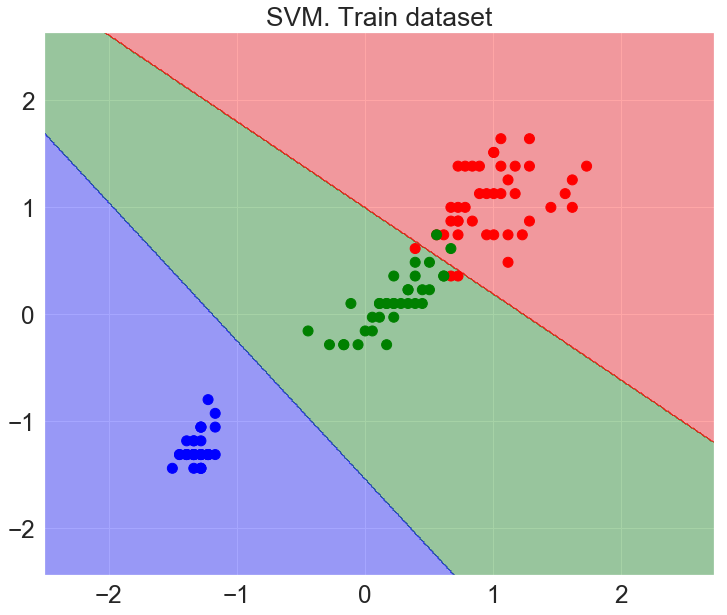

In [10]:
visualize_classification_result(X_train_std, y_train, svm, "SVM. Train dataset")

## Confusion matrix

[1 1 2 0 2 0 0 1 2 2 1 2 1 2 1 1 2 1 1 2 1 2 1 0 2 1 1 1 1 2 0 0 2 1 0 0 1
 0 2 1 0 1 2 1 0 2 2 2 2 0 0 2 2 0 2 0 2 2 0 0 2 0 0 0 1 2 2 0 0 0 1 1 0 0
 1 0 2 1 2 1 0 2 0 2 0 0 2 0 2 1 1 1 2 2 1 2 0 1 2 2 0 1 1 2 1 0 0 0 2 1 2
 0]


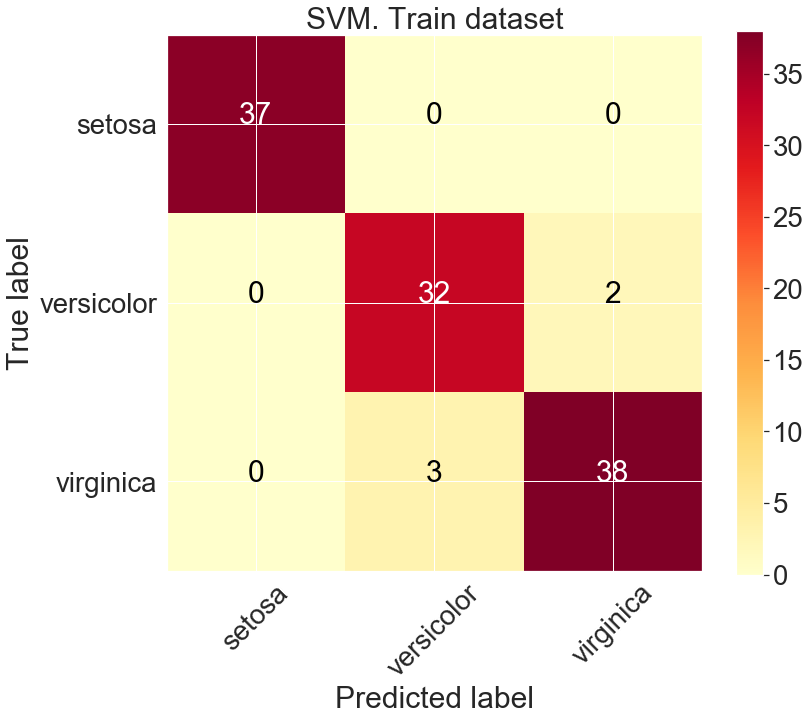

In [11]:
y_svm_train_predict = svm.predict(X_train_std)
print(y_svm_train_predict)

y_svm_train_predict_proba = svm.predict_proba(X_train_std)
#print(y_svm_train_predict_proba)
plot_confusion_matrix(y_train, y_svm_train_predict, iris.target_names, 'SVM. Train dataset')

## SVM test dataset visualization

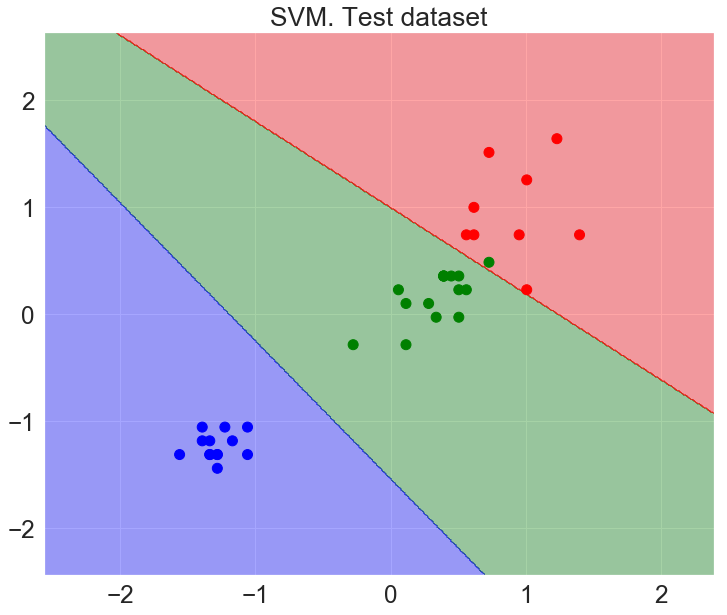

In [12]:
visualize_classification_result(X_test_std, y_test, svm, "SVM. Test dataset")

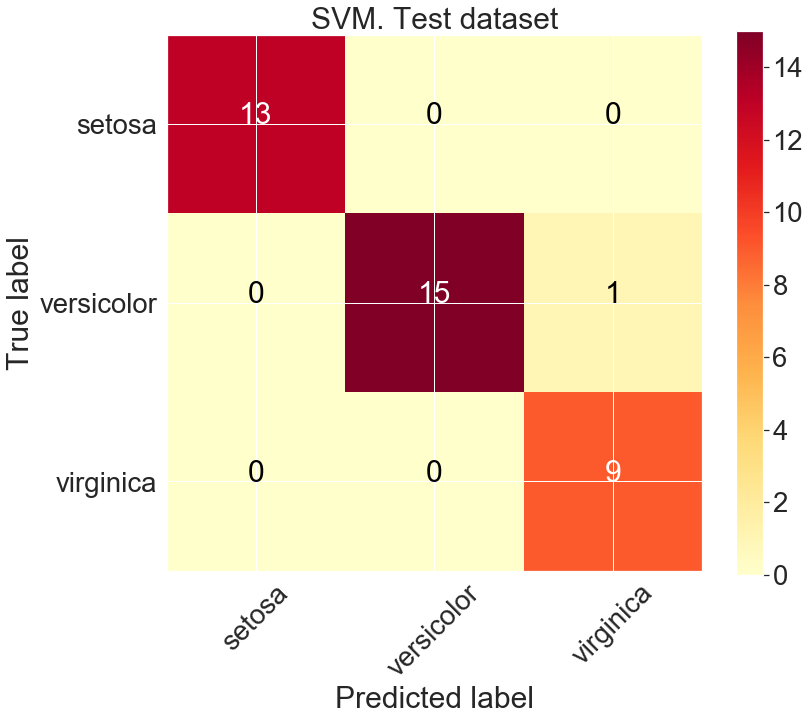

In [13]:
y_svm_test_predict = svm.predict(X_test_std)

plot_confusion_matrix(y_test, y_svm_test_predict, iris.target_names, 'SVM. Test dataset')

## KNN(kth nearest neighbour) classification

In [14]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_std, y_train)

print('The accuracy on training data: {:.1f}'.format(knn.score(X_train_std, y_train) * 100))
print('The accuracy on test data: {:.1f}'.format(knn.score(X_test_std, y_test) * 100))

The accuracy on training data: 95.5
The accuracy on test data: 100.0


## KNN training dataset visualization

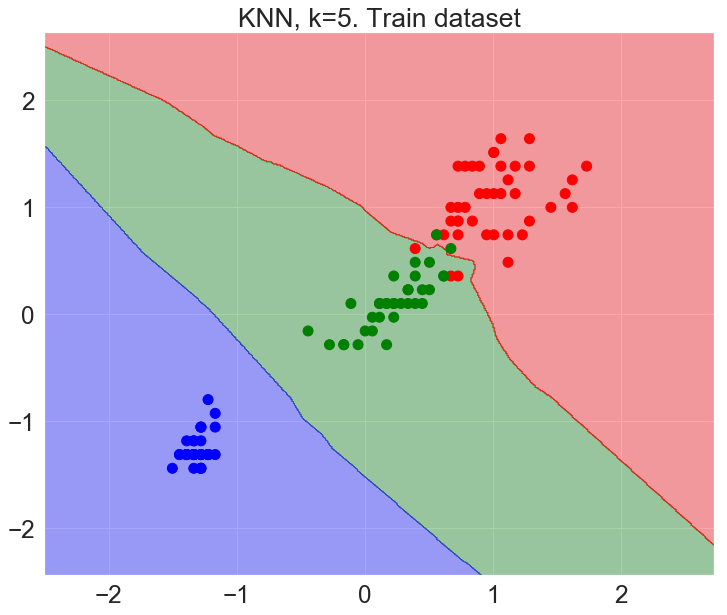

In [15]:
visualize_classification_result(X_train_std, y_train, knn, 'KNN, k=5. Train dataset')

## KNN training dataset confusion matrix

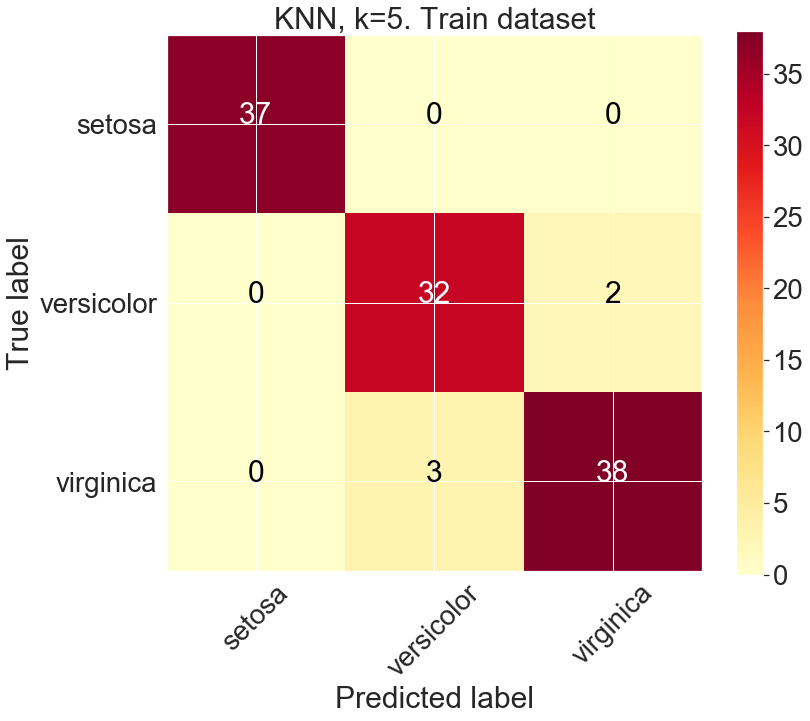

In [16]:
y_knn_train_predict = knn.predict(X_train_std)

plot_confusion_matrix(y_train, y_knn_train_predict, iris.target_names, 'KNN, k=5. Train dataset')

## KNN Roc curve

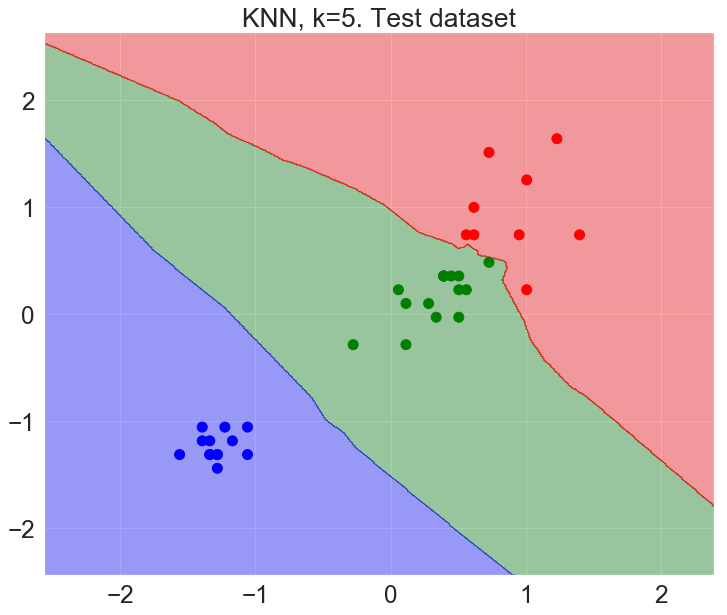

In [17]:
visualize_classification_result(X_test_std, y_test, knn, "KNN, k=5. Test dataset")

## KNN test dataset visualization

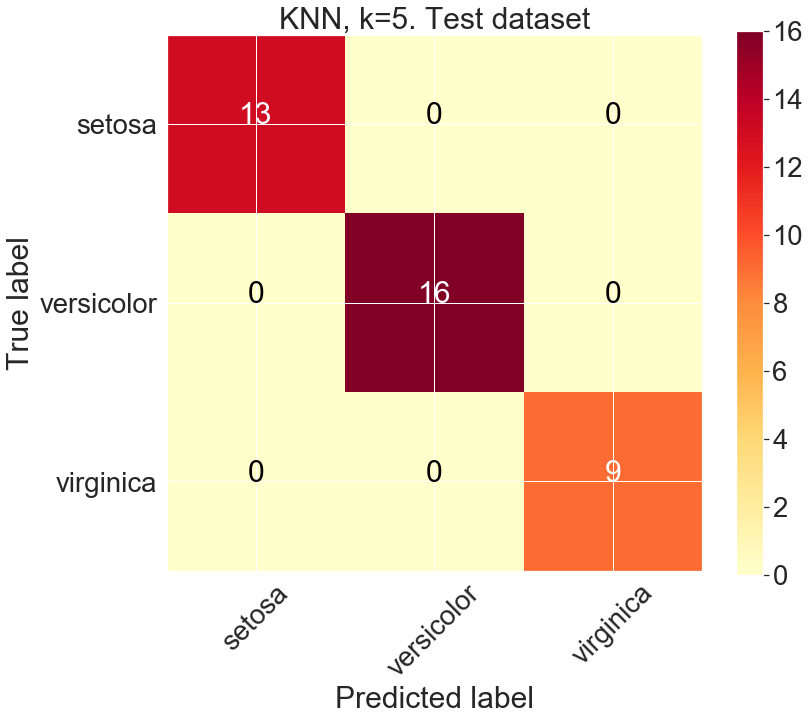

In [18]:
y_knn_test_predict = knn.predict(X_test_std)

plot_confusion_matrix(y_test, y_knn_test_predict, iris.target_names, 'KNN, k=5. Test dataset')

## Linear Regression

In [19]:
from scipy import polyval, stats

petal_length_data = X_train_std[:, 0]
petal_width_data = X_train_std[:, 1]

fit_output = stats.linregress(petal_length_data, petal_width_data)
slope, intercept, r_value, p_value, slope_std_error = fit_output

print('Slope of the regression line: {}.\nIntercept of the regression line: {}.\nCorrelation coefficient: {}.\nStandard error: {}.'.format(slope, intercept, r_value, slope_std_error))

Slope of the regression line: 0.9673506019907516.
Intercept of the regression line: -4.1544583772558667e-17.
Correlation coefficient: 0.967350601990752.
Standard error: 0.024164740058066143.


In [20]:
import matplotlib as mpl

def get_custom_red_blue_green_cmap():
    custom_rgb = ["#4C72B0", "#55A868", "#C44E52"];
    custom_cmap = mpl.colors.ListedColormap(custom_rgb)
    return custom_cmap

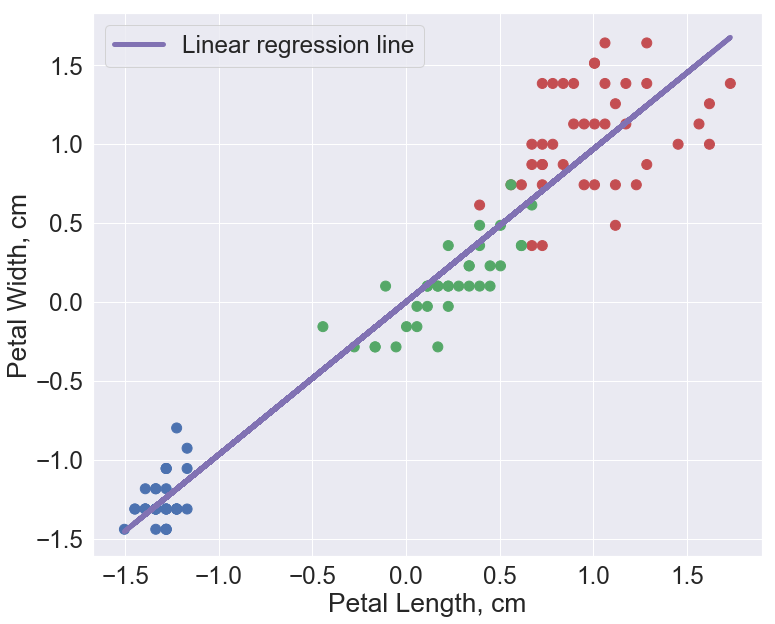

In [21]:
sns.set(font_scale=2.2, rc={'figure.figsize':(12, 10)})

plt.scatter(petal_length_data, petal_width_data, c=y_train, cmap=get_custom_red_blue_green_cmap(), s=100)
plt.plot(petal_length_data, intercept + slope*petal_length_data, 'm', linewidth=5, label='Linear regression line')

plt.ylabel('Petal Width, cm')
plt.xlabel('Petal Length, cm')
plt.legend()
plt.show()

In [22]:
def visualize_regression_line(X, y, y_predicted, title):
    lw = 2
    plt.scatter(X, y, color='darkorange', label='data')
    plt.plot(X.reshape(-1, 1), y_predicted, color='c', lw=lw, label='Linear model')
    plt.xlabel('Petal Length, cm')
    plt.ylabel('Petal Width, cm')
    plt.title(title)
    plt.legend()
    plt.show()

In [23]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR()
petal_length_train_data = X_train[:, 0]
petal_width_train_data = X_train[:, 1]

svm_reg.fit(petal_length_train_data.reshape(-1, 1), petal_width_train_data)

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)

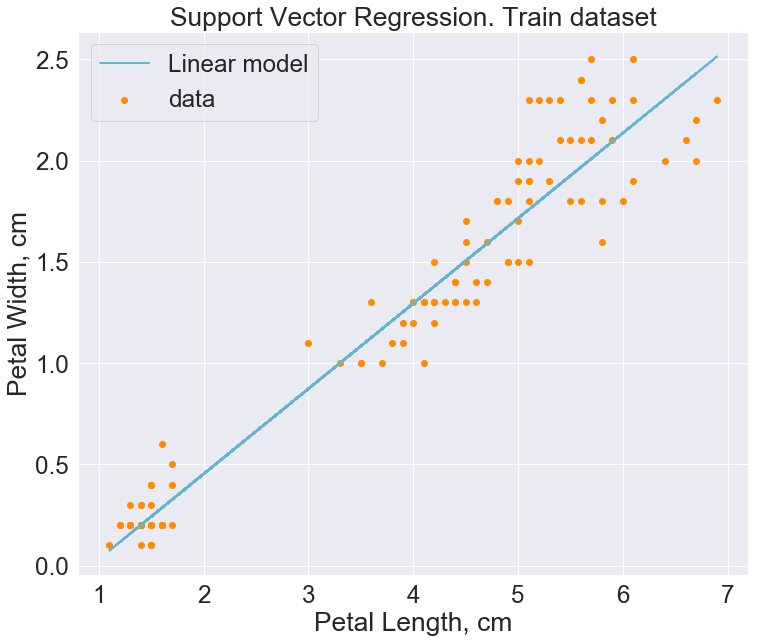

In [24]:
y_train_predicted = svm_reg.predict(petal_length_train_data.reshape(-1, 1))

visualize_regression_line(petal_length_train_data, petal_width_train_data, y_train_predicted, 'Support Vector Regression. Train dataset')